In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from bunch import Bunch
plt.style.use('ggplot')
import pandas as pd
from pandas import DataFrame, Series

In [2]:
%load_ext rpy2.ipython

In [3]:
def scale(xs):
    return (xs - xs.mean(0))/xs.std(0, ddof=1)

In [4]:
def sample(xs, n, replace=False):
    idx = np.random.choice(len(xs), n, replace=replace)
    return xs[idx]

In [5]:
def prepare(data_sets, nobs, cols, scale=False):
    C = np.concatenate([(i+1)*np.ones(nobs) for i, _ in enumerate(data_sets)]).astype('int')
    xs = np.concatenate([sample(data[:, cols], nobs) for data in data_sets])
    if scale:
        xs = scale(xs)
    idx = np.random.permutation(len(xs))
    return C[idx], xs[idx]

In [6]:
def convert_mpg(Robj):
    """Convert MPG object to nested dictioary for easy access."""
    adict = Bunch()
    for i, name1 in enumerate(Robj.names):
        adict[name1] = Bunch()
        for j, name2 in enumerate(Robj[i].names):
            adict[name1][name2] = np.array(Robj[i][j]).squeeze()
    return adict

In [7]:
def plot_diff(mpg, feature='weight', dim=[0,1], cm='jet'):
    if feature == 'weight':
        state = mpg.chain.Z > mpg.prior.K
    elif feature == 'shift':
        state = np.empty_like(mpg.chain.Z)
        for i in range(len(state)):
            state[i,:] = mpg.chain.S[i, mpg.chain.Z[i,:].astype('int')-1] == 1
    else:
        return None
    k = len(set(mpg.data.C))
    
    minx, maxx = mpg.data.Y[:, dim[0]].min(), mpg.data.Y[:, dim[0]].max()
    miny, maxy = mpg.data.Y[:, dim[1]].min(), mpg.data.Y[:, dim[1]].max()
    
    m = plt.cm.ScalarMappable(cmap=cm)
    m.set_array([0,1])

    plt.set_cmap(cm)
    plt.figure(figsize=(k*3.5, 3))
    for i in range(k):
        idx = mpg.data.C == (i+1)
        effect = state[:, idx].mean(0)
        order = np.argsort(effect)
        plt.subplot(1,k,i+1)
        plt.scatter(mpg.data.Y[idx, dim[0]][order], mpg.data.Y[idx, dim[1]][order],
                    c=np.log1p(effect[order]), edgecolors='none', alpha=1.0, vmin=0, vmax=1.0)
        plt.axis([minx, maxx, miny, maxy])
        plt.colorbar(m)
    plt.tight_layout();

Some additional prior parameters
```python
prior = list( K = 10,
              epsilons_range =  matrix( c(10^-10, 10^-1, 10^-1, 2), ncol = 2),   
              m_2 = rep(0,p),
              nu_2 = p+2, 
              nu_1 = p+2,
              Psi_2 = diag(1,p),
              S_2 = 1000*diag(1,p),
              tau_k0 = rep(4,2),
              tau_alpha = rep(1,2),
              tau_rho = c(9,1),
              point_masses_rho = c(0.0, 0.0),
              tau_varphi = c(4.5,4.5,1),
              point_masses_varphi = c(0.0, 0.0, 0.0)
)
```

Test data set
----

In [8]:
np.random.seed(10)

p = 4
mu1s = [0*np.ones(p) , 3*np.ones(p)]
sigma1s = [np.eye(p), np.eye(p)]
n1s = [300, 700]
x1 = np.concatenate([np.random.multivariate_normal(mu, sigma, n)
                     for mu, sigma, n in zip(mu1s, sigma1s, n1s)])

mu2s = [0*np.ones(p) , 3*np.ones(p)]
sigma2s = [np.eye(p), np.eye(p)]
n2s = [200, 800]
x2 = np.concatenate([np.random.multivariate_normal(mu, sigma, n)
                     for mu, sigma, n in zip(mu2s, sigma2s, n2s)])

mu3s = [0*np.ones(p) , 3.2*np.ones(p)]
sigma3s = [np.eye(p), np.eye(p)]
n3s = [300, 700]
x3 = np.concatenate([np.random.multivariate_normal(mu, sigma, n)
                     for mu, sigma, n in zip(mu3s, sigma3s, n3s)])


mu4s = [0*np.ones(p) , 4*np.ones(p)]
sigma4s = [np.eye(p), np.eye(p)]
n4s = [300, 700]
x4 = np.concatenate([np.random.multivariate_normal(mu, sigma, n)
                     for mu, sigma, n in zip(mu4s, sigma4s, n4s)])


data = [x1, x1]
data_wts = [x1, x2]
data_align = [x1, x3]
data_shift = [x1, x4]

### Sanity check - two identical data sets

In [9]:
C, Y = prepare(data, 1000, [0,1,2,3])

In [10]:
%%R -i C,Y -o ans

library(MPG)

set.seed(1)

mcmc = list(nburn = 1000, nsave = 1000, nskip = 1, ndisplay = 100, seed=123)

n = nrow(Y)
p = ncol(Y)

prior = list( K = 10 , 
              epsilons_range = matrix( c(10^-10, 1, 1, 2), ncol = 2, byrow=TRUE),
              tau_varphi = c(0.5,0.5,0))


ans = mpg(Y, C, prior, mcmc)

In [11]:
mpg = convert_mpg(ans)

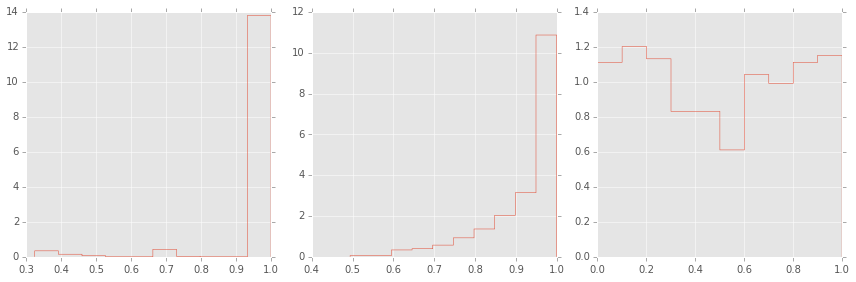

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(mpg.chain.rho, normed=True, histtype='step')
plt.subplot(1,3,2)
plt.hist(mpg.chain.varphi[:], normed=True, histtype='step')
plt.subplot(1,3,3)
plt.hist(mpg.chain.epsilon[:], normed=True, histtype='step')
plt.tight_layout()

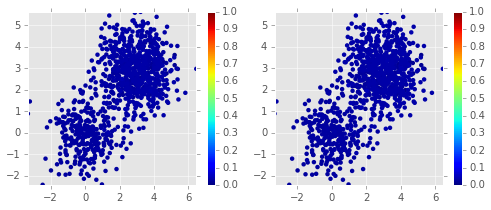

In [13]:
plot_diff(mpg, 'weight')

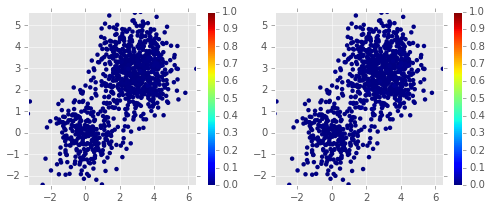

In [14]:
plot_diff(mpg, 'shift')

### Data sets with different weights

In [15]:
C_wt, Y_wt = prepare(data_wts, 1000, [0,1,2,3])

In [16]:
%%R -i C_wt,Y_wt -o ans_wt

library(MPG)

set.seed(1)

mcmc = list(nburn = 1000, nsave = 1000, nskip = 1, ndisplay = 100, seed=123)

n = nrow(Y_wt)
p = ncol(Y_wt)

prior = list( K = 10 , 
              epsilons_range = matrix( c(10^-10, 1, 1, 2), ncol = 2, byrow=TRUE),
              tau_varphi = c(0.5,0.5,0))


ans_wt = mpg(Y_wt, C_wt, prior, mcmc)

In [17]:
mpg_wt = convert_mpg(ans_wt)

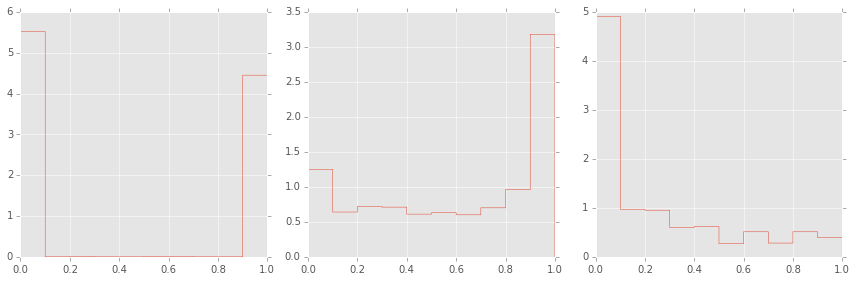

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(mpg_wt.chain.rho, normed=True, histtype='step')
plt.subplot(1,3,2)
plt.hist(mpg_wt.chain.varphi[:], normed=True, histtype='step')
plt.subplot(1,3,3)
plt.hist(mpg_wt.chain.epsilon[:], normed=True, histtype='step')
plt.tight_layout()

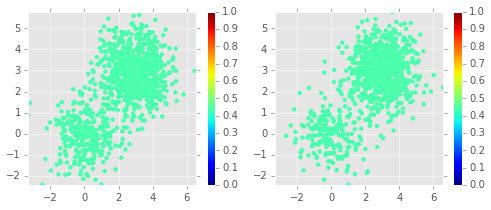

In [19]:
plot_diff(mpg_wt, 'weight')

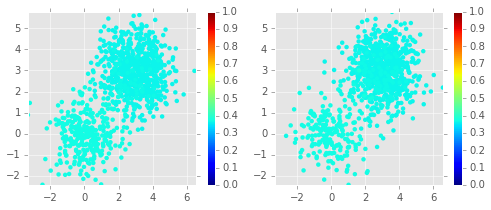

In [20]:
plot_diff(mpg_wt, 'shift')

### Data sets with small shift

In [21]:
C_align, Y_align = prepare(data_align, 1000, [0,1,2,3])

In [22]:
%%R -i C_align,Y_align -o ans_align

library(MPG)

set.seed(5)

mcmc = list(nburn = 1000, nsave = 1000, nskip = 1, ndisplay = 100, seed=123)

n = nrow(Y_align)
p = ncol(Y_align)

prior = list( K = 10 , 
              epsilons_range = matrix( c(10^-10, 1, 1, 2), ncol = 2, byrow=TRUE),
              tau_varphi = c(0.5,0.5,0))

ans_align = mpg(Y_align, C_align, prior, mcmc)

In [23]:
mpg_align = convert_mpg(ans_align)

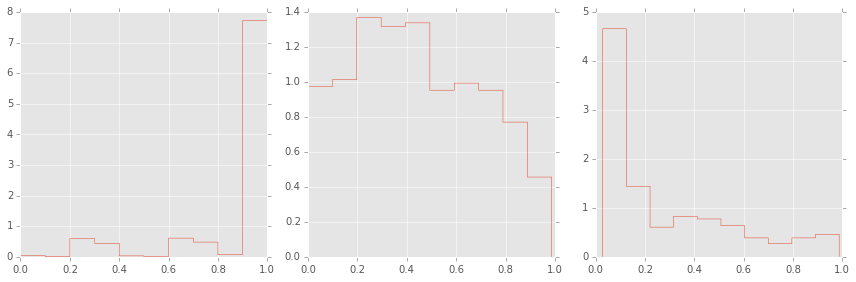

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(mpg_align.chain.rho, normed=True, histtype='step')
plt.subplot(1,3,2)
plt.hist(mpg_align.chain.varphi, normed=True, histtype='step')
plt.subplot(1,3,3)
plt.hist(mpg_align.chain.epsilon, normed=True, histtype='step')
plt.tight_layout()

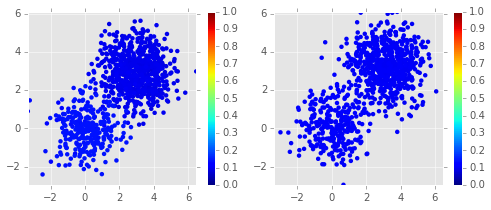

In [25]:
plot_diff(mpg_align, 'weight')

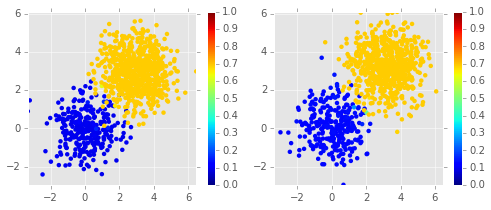

In [26]:
plot_diff(mpg_align, 'shift')

### Data sets with large shift

In [27]:
C_shift, Y_shift = prepare(data_shift, 1000, [0,1,2,3])

In [28]:
%%R -i C_shift,Y_shift -o ans_shift

library(MPG)

set.seed(1)

mcmc = list(nburn = 1000, nsave = 1000, nskip = 1, ndisplay = 100, seed=123)

n = nrow(Y_shift)
p = ncol(Y_shift)

prior = list( K = 10 , 
              epsilons_range = matrix( c(10^-10, 1, 1, 2), ncol = 2, byrow=TRUE),
              tau_varphi = c(0.5,0.5,0))

ans_shift = mpg(Y_shift, C_shift, prior, mcmc)

In [29]:
mpg_shift = convert_mpg(ans_shift)

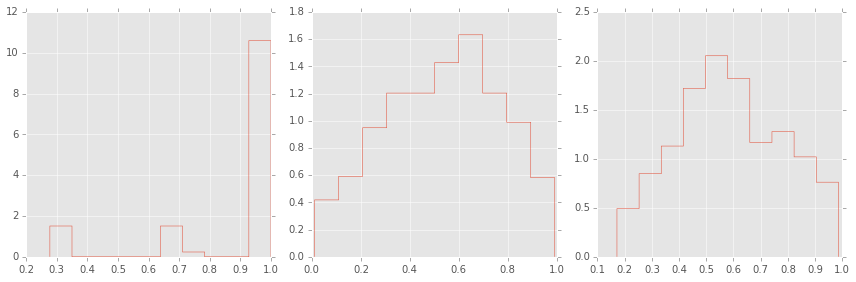

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(mpg_shift.chain.rho, normed=True, histtype='step')
plt.subplot(1,3,2)
plt.hist(mpg_shift.chain.varphi, normed=True, histtype='step')
plt.subplot(1,3,3)
plt.hist(mpg_shift.chain.epsilon, normed=True, histtype='step')
plt.tight_layout()

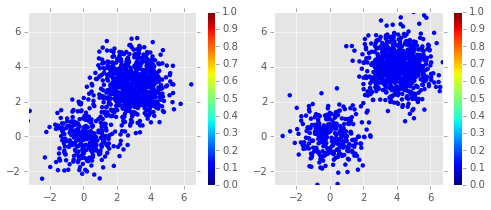

In [31]:
plot_diff(mpg_shift, 'weight')

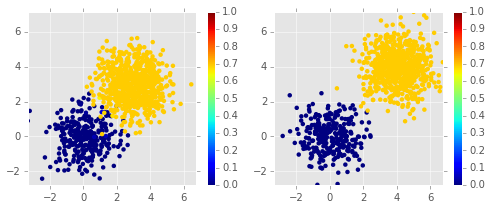

In [32]:
plot_diff(mpg_shift, 'shift')